In [1]:
import numpy as np
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from model import get_data_embedding
from torch.cuda.amp import autocast, GradScaler  # For mixed precision
import logging
import random

In [2]:
def get_trajectory_embedding(model, observations, actions, rewards, is_seaquest=False, device='cpu'):
    """
    Calculates the trajectory embedding for a given model, observations, actions, and rewards.

    Args:
        model (torch.nn.Module): The model used to calculate the embedding.
        observations (list): List of observations.
        actions (list): List of actions.
        rewards (list): List of rewards.
        stack_frames_fn (function, optional): Function to stack frames for Seaquest environment. Defaults to None.
        is_seaquest (bool, optional): Flag indicating if the environment is Seaquest. Defaults to False.

    Returns:
        list: List of trajectory embeddings.
    """
    def reshape_input(observations, actions, rewards, device='cpu'):
        input_obs = observations.view(1, -1, 4*84*84).to(device)
        input_act = actions.view(1, -1, 1).to(device)
        input_rew = rewards.view(1, -1, 1).to(device)
        timesteps = torch.as_tensor([[[1]]], dtype=torch.long).to(device)  # Adjust as needed
        return input_obs, input_act, input_rew, timesteps

    model = model.to(device)
    scaler = GradScaler()
    if is_seaquest:
        input_obs, input_act, input_rew, timesteps = reshape_input(observations[0], actions[0], rewards[0], device=device)
        embedding = model(input_obs, input_act, rtgs=input_rew, timesteps=timesteps).detach()
        MAX_SIZE = torch.mean(embedding, dim=1).flatten().shape[0]
    else:
        combined_input = torch.cat([observations[0], actions[0], rewards[0].unsqueeze(1)], dim=1).type(torch.long)
        combined_input = combined_input.to(device)
        MAX_SIZE = model(combined_input).detach().flatten().shape[0]

    filename = 'seaquest_trajectory_embedding.dat' if is_seaquest else 'halfcheetah_trajectory_embedding.dat'

    trajectory_embedding = torch.zeros((len(observations), MAX_SIZE), dtype=torch.float16, device=device)

    for ind, (obs, act, rew) in enumerate(tqdm(zip(observations, actions, rewards), total=len(observations), desc="Processing trajectories")):
        with autocast():
            if is_seaquest:
                input_obs, input_act, input_rew, timesteps = reshape_input(obs, act, rew, device=device)
                embedding = model(input_obs, input_act, rtgs=input_rew, timesteps=timesteps).detach()
                embedding = torch.mean(embedding, dim=1).flatten()
            else:
                combined_input = torch.cat([obs, act, rew.unsqueeze(1)], dim=1).type(torch.long)
                combined_input = combined_input.to(device)
                embedding = model(combined_input).detach()
                embedding = torch.mean(embedding, dim=1).flatten()
            

        embedding_size = min(len(embedding), MAX_SIZE)
        trajectory_embedding[ind, :embedding_size] = embedding[:embedding_size].cpu()

    return trajectory_embedding

In [3]:
def perform_clustering_and_plot(traj_embeddings, amount_initial_centers, max_clusters, plot=True):
    """
    Performs clustering on prepared trajectory embeddings using X-Means and plots the results.

    :param traj_embeddings: Prepared trajectory embeddings.
    :param amount_initial_centers: Initial number of centers for clustering.
    :param max_clusters: Maximum number of clusters.
    :return: None
    """
    # Create a basic logger
    logger = logging.getLogger(__name__)
    logging.basicConfig(level=logging.INFO)

    logger.info('Starting clustering process.')

    # Initialize centers using kmeans_plusplus_initializer
    initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers).initialize()

    logger.info('Initial centers initialized.')

    # Create and process X-Means instance
    xmeans_instance = xmeans(traj_embeddings, initial_centers, max_clusters)
    xmeans_instance.process()

    logger.info('X-Means instance processed.')
    
    # Extract clustering results: clusters and their centers
    clusters = xmeans_instance.get_clusters()

    logger.info('Clustering results extracted.')
    
    # Assign cluster labels to each trajectory
    traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for traj_id in cluster:
            traj_cluster_labels[traj_id] = cluster_id

    logger.info('Cluster labels assigned to each trajectory.')

    # Perform PCA for visualization
    pca_traj = PCA(n_components=2)
    pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
    plotting_data = {
        'feature 1': pca_traj_embeds[:, 0],
        'feature 2': pca_traj_embeds[:, 1],
        'cluster id': traj_cluster_labels
    }
    df = pd.DataFrame(plotting_data)

    logger.info('PCA performed for visualization.')

    if plot:
        # Plotting
        plt.figure(figsize=(4,3))
        palette = sns.color_palette('husl', len(clusters) + 1)
        sns.scatterplot(
            x='feature 1',
            y='feature 2',
            hue='cluster id',
            palette=palette[:len(clusters)],
            data=df,
            legend=True
        )
        plt.title('Trajectory Embeddings for ' + str(amount_initial_centers) + ' initial centers')
        plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
        plt.tight_layout()
        plt.show()

        logger.info('Plot created.')

    return clusters

In [4]:
import torch
from tqdm import tqdm

def create_trajectories(observations, actions, rewards, terminals, trajectory_length):
    """
    Create trajectories from the given observations, actions, rewards, and terminals.
    Parameters:
        observations (torch.Tensor): Tensor of shape [num_frames, height, width].
        stack_size (int): Number of frames to stack for each observation.
    Returns:
        torch.Tensor: Stacked observations of shape [(num_frames-stack_size+1), stack_size, height, width].
    """
    # Efficiently compute the number of trajectories
    terminal_indices = [i for i, x in enumerate(terminals) if x]
    #print("DEBUG: terminal_indices", terminal_indices)
    padded_length = sum(trajectory_length - (i % trajectory_length) for i in terminal_indices)
    total_length = len(observations) + padded_length
    num_trajectories = total_length // trajectory_length

    # Tensor shapes
    obs_shape = observations[0].shape
    act_shape = actions[0].shape
    rew_shape = rewards[0].shape
    term_shape = terminals[0].shape

    # Pre-allocate tensors
    final_obs = torch.zeros((num_trajectories, trajectory_length, *obs_shape), dtype=torch.uint8)
    final_act = torch.zeros((num_trajectories, trajectory_length, *act_shape))
    final_rew = torch.zeros((num_trajectories, trajectory_length, *rew_shape))
    final_ter = torch.zeros((num_trajectories, trajectory_length, *term_shape))

    # Populate tensors
    trajectory_idx = 0
    step_idx = 0
    for i in tqdm(range(len(observations)), desc="Processing sub'trajectories"):
        final_obs[trajectory_idx, step_idx] = torch.from_numpy(observations[i])
        final_act[trajectory_idx, step_idx] = torch.as_tensor(actions[i])
        final_rew[trajectory_idx, step_idx] = torch.as_tensor(rewards[i])
        final_ter[trajectory_idx, step_idx] = torch.as_tensor(terminals[i])
        step_idx += 1

        if terminals[i] or step_idx == trajectory_length:
            trajectory_idx += 1
            step_idx = 0
            if trajectory_idx >= num_trajectories:
                break


    return final_obs, final_act, final_rew, final_ter


In [5]:
from decision_transformer_atari.atari.mingpt.model_atari import GPTConfig, GPT
import sys
sys.path.insert(0, 'trajectory_transformer')
from trajectory_transformer.trajectory.models.transformers import GPT as TrajectoryGPT
import torch
import pickle


def load_seaquest_model(checkpoint_path="decision_transformer_atari\checkpoints\Seaquest_123.pth"):
    """
    Load the Seaquest model from a checkpoint file.

    Args:
        checkpoint_path (str): Path to the checkpoint file. Default is "decision_transformer_atari\checkpoints\Seaquest_123.pth".

    Returns:
        model (GPT): Loaded Seaquest model.
    """
    vocab_size = 18
    block_size = 90
    model_type = "reward_conditioned"
    timesteps = 2719

    mconf = GPTConfig(
        vocab_size,
        block_size,
        n_layer=6,
        n_head=8,
        n_embd=128,
        model_type=model_type,
        max_timestep=timesteps,
    )
    model = GPT(mconf)

    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)

    return model

def load_halfcheetah_model(model_path):
    """
    Loads a pre-trained transformer model from the given path.

    Args:
        model_path (str): The path to the directory containing the model files.

    Returns:
        The loaded transformer model.
    """
    model_config_path = model_path + '/model_config.pkl'
    with open(model_config_path, 'rb') as config_file:
        model_config = pickle.load(config_file)
    model = TrajectoryGPT(model_config)

    # Load the pre-trained weights
    # Choose the specific state file you want to load, e.g., state_0.pt, state_16.pt, etc.
    state_dict_path = model_path + '/state_48.pt'
    model.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))

    # If you're using a GPU, you can move the model to GPU
    # model = model.to('cuda')
    return model

ModuleNotFoundError: No module named 'decision_transformer_atari'

In [6]:
import gym
import numpy as np
import gzip
from gym import wrappers
from eorl import OfflineDataset

def stack_frames(dataset, stack_size=4):
    """
    Stack consecutive frames in the dataset with padding for initial frames.
    
    :param dataset: A numpy array of shape [num_frames, width, height]
    :param stack_size: Number of frames to stack
    :return: A numpy array of shape [num_frames, stack_size, width, height]
    """
    
    # Padding the dataset with zeros at the beginning
    padded_dataset = np.pad(dataset, ((stack_size-1, 0), (0, 0), (0, 0)), mode='constant')

    # Stacking frames
    num_frames = len(dataset)
    indices = np.arange(stack_size) + np.arange(num_frames)[:, None]
    stacked_dataset = padded_dataset[indices]

    return stacked_dataset

def load_seaquest_dataset(env_name, size = 717):


    # Load the dataset
    ds = OfflineDataset(
    env = env_name,            # pass name in supported environments below
    dataset_size = 1e6,   # [0, 1e6) frames of atari
    train_split = 0.9,       # 90% training, 10% held out for testing
    obs_only = False,        # only get observations (no actions, rewards, dones)
    framestack = 1,          # number of frames per sample
    shuffle = False,         # chronological samples if False, randomly sampled if true
    stride = 1,               # return every stride`th chunk (where chunk size == `framestack)
    verbose = 1,              # 0 = silent, >0 for reporting
    )

    # Extract the dataset
    datasets = {
        'observations': ds.dataset['observation'],
        'actions': ds.dataset['action'],
        'rewards': ds.dataset['reward'],
        'terminals': ds.dataset['terminal']
    }

    
    
    print("Dataset loaded")
    seaquest_length = np.where(np.cumsum(datasets["terminals"]) == size)[0][0]  # Note if terminals are not binary this will not work.
    datasets['observations'] = stack_frames(datasets['observations'][:seaquest_length])

    datasets['observations'] = datasets['observations'][:seaquest_length]
    datasets['actions'] = datasets['actions'][:seaquest_length]
    datasets['rewards'] = datasets['rewards'][:seaquest_length]
    datasets['terminals'] = datasets['terminals'][:seaquest_length]

    # Initialize the Gym environment
    env_name = 'ALE/' + env_name + '-ram-v5'
    env = gym.make(env_name)

    env = gym.wrappers.ResizeObservation(env, (84, 84))

    # Print logging information
    print(f"Dataset extracted with {len(datasets['observations'])} samples.")
    print("Information about the dataset:")
    print("Observation shape: ",datasets['observations'].shape)
    print("Action shape: ",datasets['actions'].shape)
    print("Reward shape: ",datasets['rewards'].shape)
    print("Terminal shape: ",datasets['terminals'].shape)
    # Action space is discrete, so we can just print the number of actions
    print("Action space: ",env.action_space.n)
    print("Observation space: ",env.observation_space.shape)
    print("Number of terminal states is...", datasets['terminals'].sum())
    print(f"Environment '{env_name}' initialized.")

    return datasets, env

In [14]:
from mk_patch_decision_transformer_atari import GPTConfig, GPT
#import sys
#sys.path.insert(0, 'trajectory_transformer')
from mk_patch_trajectory_transformer import GPT as TrajectoryGPT
import torch
import pickle

def load_seaquest_model(checkpoint_path="decision_transformer_atari\checkpoints\Seaquest_123.pth"):
    """
    Load the Seaquest model from a checkpoint file.

    Args:
        checkpoint_path (str): Path to the checkpoint file. Default is "decision_transformer_atari\checkpoints\Seaquest_123.pth".

    Returns:
        model (GPT): Loaded Seaquest model.
    """
    vocab_size = 18 # 18 for Seaquest
    block_size = 90
    model_type = "reward_conditioned"
    timesteps = 2719 # 2719 for Seaquest

    mconf = GPTConfig(
        vocab_size,
        block_size,
        n_layer=6,
        n_head=8,
        n_embd=128,
        model_type=model_type,
        max_timestep=timesteps,
    )
    model = GPT(mconf)

    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)

    return model

ModuleNotFoundError: No module named 'trajectory_transformer'

In [9]:
data_size = 50
test_size = 5
seaquestdata, sq_env = load_seaquest_dataset(env_name='Seaquest', size=data_size+test_size)

decompressing data...
Dataset loaded
Dataset extracted with 96636 samples.
Information about the dataset:
Observation shape:  (96636, 4, 84, 84)
Action shape:  (96636,)
Reward shape:  (96636,)
Terminal shape:  (96636,)
Action space:  18
Observation space:  (84, 84)
Number of terminal states is... 54
Environment 'ALE/Seaquest-ram-v5' initialized.


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [10]:
terminal_indexes = np.where(seaquestdata['terminals'] == True)[0]
trunc = terminal_indexes[-test_size]
terminal_indexes = terminal_indexes[data_size:] # Get index of first trajectory that we want to draw

test_observations = []
test_actions = []
for i in range(len(terminal_indexes)):
    ind = [i + np.random.randint(200, 300)]
    test_observations.append(seaquestdata['observations'][ind])
    test_actions.append(seaquestdata['actions'][ind][0])

In [11]:
import copy

In [12]:
observation = copy.deepcopy(test_observations[0])

# Observation has shape (1, 4, 84, 84)
# We need to remove the first dimension
# and plot each channel separately
observation = observation.squeeze()
print("Observation Shape:", observation.shape)
print('Test observation shape: ', test_observations[0].shape)

# assert test_observations[0].shape == (1, 4, 84, 84)
# if not, drop the first dimension
if test_observations[0].shape != (1, 4, 84, 84):
    test_observations[0] = test_observations[0].squeeze()
    print('Test observation shape after squeezing: ', test_observations[0].shape)


# Remove all the previous observations, actions, rewards and terminals
seaquestdata["observations"] = seaquestdata["observations"][:trunc]
seaquestdata["actions"] = seaquestdata["actions"][:trunc]
seaquestdata["rewards"] = seaquestdata["rewards"][:trunc]
seaquestdata["terminals"] = seaquestdata["terminals"][:trunc]

Observation Shape: (4, 84, 84)
Test observation shape:  (1, 4, 84, 84)


In [13]:
pre_trained_encoder_seaquest = load_seaquest_model("decision_transformer_atari/checkpoints/Seaquest_123.pth")

NameError: name 'GPTConfig' is not defined

In [13]:
final_obs_sq, final_act_sq, final_rew_sq, _ = create_trajectories(
        seaquestdata["observations"], seaquestdata["actions"], 
        seaquestdata["rewards"], seaquestdata["terminals"], trajectory_length=30
    )

Processing sub'trajectories: 100%|██████████| 49614/49614 [00:01<00:00, 41952.86it/s]


In [14]:
final_obs_sq.shape

torch.Size([1677, 30, 4, 84, 84])

In [15]:
final_obs_sq[0].shape, final_act_sq[0], final_rew_sq[0]

(torch.Size([30, 4, 84, 84]),
 tensor([15.,  7., 15.,  7., 15., 15., 15., 15., 15., 15., 15.,  3.,  7.,  3.,
          3., 15., 15.,  7.,  7.,  7.,  7.,  7.,  3., 15., 15., 15.,  3., 15.,
         15., 15.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]))

In [16]:
device = 'cpu'

In [ ]:
trajectory_embedding_seaquest = get_trajectory_embedding(
        pre_trained_encoder_seaquest, final_obs_sq, final_act_sq, final_rew_sq, 
        is_seaquest=True, device= device
    )

In [18]:
clusters_seaquest = perform_clustering_and_plot(trajectory_embedding_seaquest.detach().cpu(), 2, 8, plot=False)


In [19]:
from d3rlpy.dataset import Episode 
import d3rlpy
from encoder import CustomCNNFactory
import torch
import numpy as np

def make_episodes(final_obs, final_act, final_rew, max_action_values):
    list_episodes = []
    for i in range(len(final_obs)):
        list_episodes.append(Episode(final_obs[i].numpy().shape[1:], max_action_values, final_obs[i].numpy(), final_act[i].numpy(), final_rew[i].numpy()))
    return list_episodes

In [20]:
list_episodes_sq = make_episodes(final_obs_sq, final_act_sq, final_rew_sq, 18)

In [21]:
def fit_discrete_sac(list_episodes, n_steps=1000, n_steps_per_epoch=100, device='cpu'):
    cuda_check = True if device == 'cuda' else False
    feature_size = 128
    custom_encoder_actor = CustomCNNFactory(feature_size)
    custom_encoder_critic = CustomCNNFactory(feature_size)

    # Train an agent on the new data
    sac_sq = d3rlpy.algos.DiscreteSAC(
            actor_learning_rate=3e-4,
            critic_learning_rate=3e-4,
            temp_learning_rate=3e-4,
            batch_size=256,
            actor_encoder_factory= custom_encoder_actor,
            critic_encoder_factory= custom_encoder_critic,
            scaler='pixel',
            target_update_interval=2500,
            use_gpu=cuda_check)
    
    sac_sq.fit(list_episodes, n_steps=n_steps, n_steps_per_epoch=n_steps_per_epoch)

    return sac_sq

In [22]:
sac_sq = fit_discrete_sac(list_episodes_sq, n_steps=10, n_steps_per_epoch=1, device=device)

2024-02-01 21:12.51 [debug    ] RandomIterator is selected.
2024-02-01 21:12.51 [info     ] Directory is created at d3rlpy_logs/DiscreteSAC_20240201211251
2024-02-01 21:12.51 [debug    ] Fitting scaler...              scaler=pixel
2024-02-01 21:12.51 [debug    ] Building models...
2024-02-01 21:12.51 [debug    ] Models have been built.
2024-02-01 21:12.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'custom', 'params': {'feature_size': 128}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 0.0001, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxlen': 100000,

Epoch 1/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0569, temp=1, critic_loss=4.52, actor_loss=-2.86]

2024-02-01 21:12.53 [info     ] DiscreteSAC_20240201211251: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.002602100372314453, 'time_algorithm_update': 2.027575969696045, 'temp_loss': 0.056895941495895386, 'temp': 0.9997005462646484, 'critic_loss': 4.521823883056641, 'actor_loss': -2.863555908203125, 'time_step': 2.0307559967041016} step=1
2024-02-01 21:12.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.46, actor_loss=-2.87]

2024-02-01 21:12.55 [info     ] DiscreteSAC_20240201211251: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.002863168716430664, 'time_algorithm_update': 1.9616129398345947, 'temp_loss': 0.0569131076335907, 'temp': 0.9994012117385864, 'critic_loss': 4.455878734588623, 'actor_loss': -2.8722164630889893, 'time_step': 1.965097188949585} step=2
2024-02-01 21:12.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.59, actor_loss=-2.88]

2024-02-01 21:12.57 [info     ] DiscreteSAC_20240201211251: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.002264738082885742, 'time_algorithm_update': 1.9589459896087646, 'temp_loss': 0.05692661181092262, 'temp': 0.999101996421814, 'critic_loss': 4.586240291595459, 'actor_loss': -2.8832783699035645, 'time_step': 1.961709976196289} step=3
2024-02-01 21:12.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.51, actor_loss=-2.9]

2024-02-01 21:12.59 [info     ] DiscreteSAC_20240201211251: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.00234222412109375, 'time_algorithm_update': 1.9823486804962158, 'temp_loss': 0.05693720653653145, 'temp': 0.9988027811050415, 'critic_loss': 4.51205587387085, 'actor_loss': -2.8992857933044434, 'time_step': 1.985243797302246} step=4
2024-02-01 21:12.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.43, actor_loss=-2.92]

2024-02-01 21:13.01 [info     ] DiscreteSAC_20240201211251: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0020639896392822266, 'time_algorithm_update': 1.9855680465698242, 'temp_loss': 0.05694347992539406, 'temp': 0.9985037446022034, 'critic_loss': 4.434284210205078, 'actor_loss': -2.9180233478546143, 'time_step': 1.9881951808929443} step=5
2024-02-01 21:13.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.29, actor_loss=-2.94]

2024-02-01 21:13.03 [info     ] DiscreteSAC_20240201211251: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0020780563354492188, 'time_algorithm_update': 1.9866900444030762, 'temp_loss': 0.056949228048324585, 'temp': 0.9982047080993652, 'critic_loss': 4.289266586303711, 'actor_loss': -2.9423670768737793, 'time_step': 1.9892737865447998} step=6
2024-02-01 21:13.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.057, temp=0.998, critic_loss=4.25, actor_loss=-2.97]

2024-02-01 21:13.05 [info     ] DiscreteSAC_20240201211251: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.0024099349975585938, 'time_algorithm_update': 1.9738390445709229, 'temp_loss': 0.056953947991132736, 'temp': 0.9979057908058167, 'critic_loss': 4.252654552459717, 'actor_loss': -2.9749579429626465, 'time_step': 1.9769108295440674} step=7
2024-02-01 21:13.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.057, temp=0.998, critic_loss=4.2, actor_loss=-3.02]

2024-02-01 21:13.07 [info     ] DiscreteSAC_20240201211251: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.002330780029296875, 'time_algorithm_update': 1.9868278503417969, 'temp_loss': 0.056957535445690155, 'temp': 0.9976069927215576, 'critic_loss': 4.203243732452393, 'actor_loss': -3.016062021255493, 'time_step': 1.9896800518035889} step=8
2024-02-01 21:13.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.057, temp=0.997, critic_loss=4, actor_loss=-3.07]

2024-02-01 21:13.09 [info     ] DiscreteSAC_20240201211251: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0021491050720214844, 'time_algorithm_update': 1.9741220474243164, 'temp_loss': 0.056959401816129684, 'temp': 0.9973082542419434, 'critic_loss': 3.999593734741211, 'actor_loss': -3.071657180786133, 'time_step': 1.9768297672271729} step=9
2024-02-01 21:13.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.057, temp=0.997, critic_loss=3.99, actor_loss=-3.14]

2024-02-01 21:13.11 [info     ] DiscreteSAC_20240201211251: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.0022840499877929688, 'time_algorithm_update': 2.006650924682617, 'temp_loss': 0.05695614963769913, 'temp': 0.9970095753669739, 'critic_loss': 3.985459804534912, 'actor_loss': -3.1388988494873047, 'time_step': 2.00954008102417} step=10
2024-02-01 21:13.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211251/model_10.pt


In [23]:
action_dict = {0: 'NOOP', 1: 'FIRE', 2: 'UP', 3: 'RIGHT', 4: 'LEFT', 5: 'DOWN', 6: 'UPRIGHT', 7: 'UPLEFT', 8: 'DOWNRIGHT', 9: 'DOWNLEFT', 10: 'UPFIRE', 11: 'RIGHTFIRE', 12: 'LEFTFIRE', 13: 'DOWNFIRE', 14: 'UPRIGHTFIRE', 15: 'UPLEFTFIRE', 16: 'DOWNRIGHTFIRE', 17: 'DOWNLEFTFIRE'}

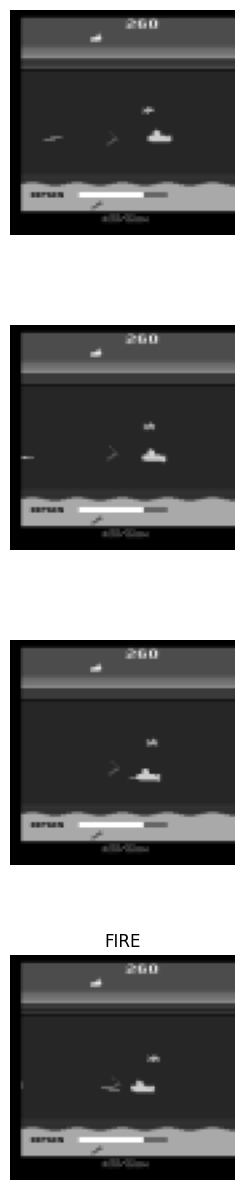

In [24]:
plt.figure(figsize=(10, 12))  # Adjust the figure size
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.imshow(observation[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

    if i == 3:
        action = sac_sq.predict(np.expand_dims(observation, axis=0))
        plt.title(action_dict[action[0]])

plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing
plt.savefig('test_observation_stack.png')

In [25]:
feature_size = 128
custom_encoder_actor = CustomCNNFactory(feature_size)
custom_encoder_critic = CustomCNNFactory(feature_size)

model_params_sq = {
'actor_learning_rate': 3e-4,
'critic_learning_rate': 3e-4,
'temp_learning_rate': 3e-4,
'batch_size': 256,
'actor_encoder_factory': custom_encoder_actor,
'critic_encoder_factory': custom_encoder_critic,
'scaler': 'pixel',
'use_gpu': True if device == 'cuda' else False
}

In [26]:
def fit_per_cluster(model, 
                    model_class, 
                    model_params, 
                    data_embedding, 
                    list_episodes, 
                    clusters, 
                    trajectory_embedding, 
                    test_observations):
    
    original_actions = []
    original_action_values = []
    for t in test_observations:
        action = model.predict(t)
        print("Original model action: ", action)
        action_value = model.predict_value(t, action = action)
        print("Original model action value: ", action_value)
        print("Passing: ", action[0], action_value[0])
        original_actions.append(action[0])
        original_action_values.append(action_value[0])

    result_data_combinations = {0:(original_actions, original_action_values, get_data_embedding(data_embedding))} # Original dataset policy
    models = {0:(model, get_data_embedding(data_embedding))}
    
    for cluster_id, cluster in enumerate(clusters):
        model = model_class(**model_params)
        count_in_clusters = 0
        count_not_in_clusters = 0
        temp_data = []
        temp_traj_embeds = []
        temp_cluster_traj_embeds = []
        for traj_id, traj in enumerate(list_episodes):
            if traj_id not in cluster:
                temp_data.append(list_episodes[traj_id])
                temp_traj_embeds.append(trajectory_embedding[traj_id])
                count_not_in_clusters += 1
            else:
                temp_cluster_traj_embeds.append(trajectory_embedding[traj_id])
                count_in_clusters += 1
        print('-'*100)
        print(f'Cluster {cluster_id + 1} has {count_in_clusters} trajectories out of {count_not_in_clusters + count_in_clusters}')
        print('-'*100)
        
        # Generate the data embedding
        data_embedding_new = get_data_embedding(temp_traj_embeds)
        # Train an agent on the new data
        model.fit(temp_data, n_steps=10, n_steps_per_epoch=1)

        models[cluster_id + 1] = (model, data_embedding_new)

        new_actions = []
        new_action_values = []
        for t in test_observations:
            action = model.predict(t)
            print("New model action: ", action)
            action_value = model.predict_value(t, action = action)
            print("New model action value: ", action_value)
            print("Passing: ", action[0], action_value[0])

            new_actions.append(action[0])
            new_action_values.append(action_value[0])
        
        result_data_combinations[cluster_id + 1] = (new_actions, new_action_values, data_embedding_new) # Clustered dataset policy (cluster_id + 1 because 0 is the original dataset)
                                                                                    # so each value is the model trained on original data - cluster 1, original data - cluster 2, etc.
        
    return models, result_data_combinations

In [27]:
def get_data_embedding(traj_embeddings):
    # Convert to numpy arrays if the embeddings are PyTorch tensors
    if isinstance(traj_embeddings[0], torch.Tensor):
        #traj_embeddings = traj_embeddings
        traj_embeddings = [te.cpu().numpy() for te in traj_embeddings]

    # Compute the sum of the embeddings, dividing by 10
    summed_embeddings = np.array(traj_embeddings).sum(axis=0) / 10.0

    # Apply softmax to the summed embeddings
    max_embeddings = np.max(summed_embeddings)
    exp_embeddings = np.exp(summed_embeddings - max_embeddings)
    softmax_embeddings = exp_embeddings / np.sum(exp_embeddings, axis=0)

    return softmax_embeddings

In [28]:
models_sq, result_data_combinations_sq = fit_per_cluster(
        model= sac_sq, 
        model_class = d3rlpy.algos.DiscreteSAC,
        model_params=model_params_sq,
        data_embedding=trajectory_embedding_seaquest,
        list_episodes=list_episodes_sq,
        clusters=clusters_seaquest,
        trajectory_embedding=trajectory_embedding_seaquest,
        test_observations=test_observations)

Original model action:  [1]
Original model action value:  [0.32215434]
Passing:  1 0.32215434
Original model action:  [1]
Original model action value:  [0.3204304]
Passing:  1 0.3204304
Original model action:  [1]
Original model action value:  [0.31940165]
Passing:  1 0.31940165
Original model action:  [1]
Original model action value:  [0.322946]
Passing:  1 0.322946
----------------------------------------------------------------------------------------------------
Cluster 1 has 21 trajectories out of 1677
----------------------------------------------------------------------------------------------------
2024-02-01 21:13.12 [debug    ] RandomIterator is selected.
2024-02-01 21:13.12 [info     ] Directory is created at d3rlpy_logs/DiscreteSAC_20240201211312
2024-02-01 21:13.12 [debug    ] Fitting scaler...              scaler=pixel
2024-02-01 21:13.12 [debug    ] Building models...
2024-02-01 21:13.12 [debug    ] Models have been built.
2024-02-01 21:13.12 [info     ] Parameters are s

Epoch 1/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0566, temp=1, critic_loss=4.52, actor_loss=-2.87]

2024-02-01 21:13.14 [info     ] DiscreteSAC_20240201211312: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.002476930618286133, 'time_algorithm_update': 2.0375912189483643, 'temp_loss': 0.056597039103507996, 'temp': 0.9997005462646484, 'critic_loss': 4.5199737548828125, 'actor_loss': -2.8688533306121826, 'time_step': 2.0407092571258545} step=1
2024-02-01 21:13.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.65, actor_loss=-2.88]

2024-02-01 21:13.16 [info     ] DiscreteSAC_20240201211312: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.002113819122314453, 'time_algorithm_update': 2.0703392028808594, 'temp_loss': 0.05667811632156372, 'temp': 0.9994012117385864, 'critic_loss': 4.648149490356445, 'actor_loss': -2.876819133758545, 'time_step': 2.0731570720672607} step=2
2024-02-01 21:13.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.46, actor_loss=-2.89]

2024-02-01 21:13.18 [info     ] DiscreteSAC_20240201211312: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.002660989761352539, 'time_algorithm_update': 2.059028148651123, 'temp_loss': 0.05673956125974655, 'temp': 0.9991019368171692, 'critic_loss': 4.46121883392334, 'actor_loss': -2.8865702152252197, 'time_step': 2.0622169971466064} step=3
2024-02-01 21:13.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.4, actor_loss=-2.9]

2024-02-01 21:13.20 [info     ] DiscreteSAC_20240201211312: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.002850055694580078, 'time_algorithm_update': 2.0593979358673096, 'temp_loss': 0.05678727477788925, 'temp': 0.9988027811050415, 'critic_loss': 4.4044904708862305, 'actor_loss': -2.8984386920928955, 'time_step': 2.0627689361572266} step=4
2024-02-01 21:13.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.25, actor_loss=-2.91]

2024-02-01 21:13.22 [info     ] DiscreteSAC_20240201211312: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0026459693908691406, 'time_algorithm_update': 2.0585782527923584, 'temp_loss': 0.056827761232852936, 'temp': 0.9985036253929138, 'critic_loss': 4.248154163360596, 'actor_loss': -2.913200616836548, 'time_step': 2.061828136444092} step=5
2024-02-01 21:13.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.37, actor_loss=-2.93]

2024-02-01 21:13.24 [info     ] DiscreteSAC_20240201211312: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0030210018157958984, 'time_algorithm_update': 2.1280550956726074, 'temp_loss': 0.056858502328395844, 'temp': 0.9982045888900757, 'critic_loss': 4.368603706359863, 'actor_loss': -2.9327635765075684, 'time_step': 2.1316442489624023} step=6
2024-02-01 21:13.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.38, actor_loss=-2.96]

2024-02-01 21:13.27 [info     ] DiscreteSAC_20240201211312: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.0034189224243164062, 'time_algorithm_update': 2.0779640674591064, 'temp_loss': 0.05688966065645218, 'temp': 0.9979055523872375, 'critic_loss': 4.383411407470703, 'actor_loss': -2.9603395462036133, 'time_step': 2.081925868988037} step=7
2024-02-01 21:13.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.31, actor_loss=-3]

2024-02-01 21:13.29 [info     ] DiscreteSAC_20240201211312: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.003058910369873047, 'time_algorithm_update': 2.040431022644043, 'temp_loss': 0.05691774934530258, 'temp': 0.997606635093689, 'critic_loss': 4.313006401062012, 'actor_loss': -2.9975247383117676, 'time_step': 2.044036865234375} step=8
2024-02-01 21:13.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0569, temp=0.997, critic_loss=4.17, actor_loss=-3.05]

2024-02-01 21:13.31 [info     ] DiscreteSAC_20240201211312: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.003401041030883789, 'time_algorithm_update': 2.0105879306793213, 'temp_loss': 0.05694097280502319, 'temp': 0.9973077774047852, 'critic_loss': 4.167320251464844, 'actor_loss': -3.047321081161499, 'time_step': 2.01452898979187} step=9
2024-02-01 21:13.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.057, temp=0.997, critic_loss=4, actor_loss=-3.11]

2024-02-01 21:13.33 [info     ] DiscreteSAC_20240201211312: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.003434896469116211, 'time_algorithm_update': 1.9810740947723389, 'temp_loss': 0.05695587396621704, 'temp': 0.9970089793205261, 'critic_loss': 3.9961748123168945, 'actor_loss': -3.1145598888397217, 'time_step': 1.9850099086761475} step=10
2024-02-01 21:13.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211312/model_10.pt
New model action:  [6]
New model action value:  [0.3419367]
Passing:  6 0.3419367
New model action:  [6]
New model action value:  [0.33837727]
Passing:  6 0.33837727
New model action:  [6]
New model action value:  [0.33721173]
Passing:  6 0.33721173
New model action:  [6]
New model action value:  [0.3399622]
Passing:  6 0.3399622
----------------------------------------------------------------------------------------------------
Cluster 2 has 67 trajectories out of 1677
--------------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0564, temp=1, critic_loss=4.52, actor_loss=-2.86]

2024-02-01 21:13.35 [info     ] DiscreteSAC_20240201211333: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0032279491424560547, 'time_algorithm_update': 1.9837491512298584, 'temp_loss': 0.056367333978414536, 'temp': 0.9997006058692932, 'critic_loss': 4.519977569580078, 'actor_loss': -2.863523006439209, 'time_step': 1.987490177154541} step=1
2024-02-01 21:13.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.52, actor_loss=-2.87]

2024-02-01 21:13.37 [info     ] DiscreteSAC_20240201211333: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.0031731128692626953, 'time_algorithm_update': 2.0162858963012695, 'temp_loss': 0.05650261789560318, 'temp': 0.9994012117385864, 'critic_loss': 4.5190958976745605, 'actor_loss': -2.8685567378997803, 'time_step': 2.0202107429504395} step=2
2024-02-01 21:13.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0566, temp=0.999, critic_loss=4.45, actor_loss=-2.87]

2024-02-01 21:13.39 [info     ] DiscreteSAC_20240201211333: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.003668069839477539, 'time_algorithm_update': 2.0307366847991943, 'temp_loss': 0.05659816786646843, 'temp': 0.9991019368171692, 'critic_loss': 4.448627471923828, 'actor_loss': -2.874162435531616, 'time_step': 2.0349161624908447} step=3
2024-02-01 21:13.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.45, actor_loss=-2.88]

2024-02-01 21:13.41 [info     ] DiscreteSAC_20240201211333: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.005146980285644531, 'time_algorithm_update': 2.029859781265259, 'temp_loss': 0.05667264014482498, 'temp': 0.9988027215003967, 'critic_loss': 4.454352378845215, 'actor_loss': -2.8810675144195557, 'time_step': 2.0355913639068604} step=4
2024-02-01 21:13.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.44, actor_loss=-2.89]

2024-02-01 21:13.43 [info     ] DiscreteSAC_20240201211333: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.003244161605834961, 'time_algorithm_update': 2.071505069732666, 'temp_loss': 0.05672910064458847, 'temp': 0.998503565788269, 'critic_loss': 4.4425740242004395, 'actor_loss': -2.890504837036133, 'time_step': 2.0754339694976807} step=5
2024-02-01 21:13.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0568, temp=0.998, critic_loss=4.45, actor_loss=-2.9]

2024-02-01 21:13.45 [info     ] DiscreteSAC_20240201211333: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0030090808868408203, 'time_algorithm_update': 1.9902737140655518, 'temp_loss': 0.05677219107747078, 'temp': 0.9982044696807861, 'critic_loss': 4.445353031158447, 'actor_loss': -2.9020562171936035, 'time_step': 1.993861198425293} step=6
2024-02-01 21:13.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0568, temp=0.998, critic_loss=4.43, actor_loss=-2.92]

2024-02-01 21:13.47 [info     ] DiscreteSAC_20240201211333: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.003492116928100586, 'time_algorithm_update': 1.9844138622283936, 'temp_loss': 0.05680602788925171, 'temp': 0.997905433177948, 'critic_loss': 4.425166130065918, 'actor_loss': -2.9182016849517822, 'time_step': 1.9884488582611084} step=7
2024-02-01 21:13.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, temp_loss=0.0568, temp=0.998, critic_loss=4.35, actor_loss=-2.94]

2024-02-01 21:13.49 [info     ] DiscreteSAC_20240201211333: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0037088394165039062, 'time_algorithm_update': 1.9967408180236816, 'temp_loss': 0.05683453753590584, 'temp': 0.9976064562797546, 'critic_loss': 4.34909725189209, 'actor_loss': -2.941591262817383, 'time_step': 2.000966787338257} step=8
2024-02-01 21:13.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, temp_loss=0.0569, temp=0.997, critic_loss=4.24, actor_loss=-2.97]

2024-02-01 21:13.51 [info     ] DiscreteSAC_20240201211333: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.003173828125, 'time_algorithm_update': 2.0005319118499756, 'temp_loss': 0.056862518191337585, 'temp': 0.997307538986206, 'critic_loss': 4.241878509521484, 'actor_loss': -2.973501443862915, 'time_step': 2.0042192935943604} step=9
2024-02-01 21:13.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, temp_loss=0.0569, temp=0.997, critic_loss=4.15, actor_loss=-3.01]

2024-02-01 21:13.53 [info     ] DiscreteSAC_20240201211333: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.003072977066040039, 'time_algorithm_update': 2.059161901473999, 'temp_loss': 0.05688212811946869, 'temp': 0.9970086812973022, 'critic_loss': 4.148664951324463, 'actor_loss': -3.0129520893096924, 'time_step': 2.062775135040283} step=10
2024-02-01 21:13.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211333/model_10.pt
New model action:  [15]
New model action value:  [0.38293064]
Passing:  15 0.38293064
New model action:  [15]
New model action value:  [0.38008213]
Passing:  15 0.38008213
New model action:  [15]
New model action value:  [0.37989616]
Passing:  15 0.37989616
New model action:  [15]
New model action value:  [0.38358974]
Passing:  15 0.38358974
----------------------------------------------------------------------------------------------------
Cluster 3 has 333 trajectories out of 1677
----------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, temp_loss=0.0563, temp=1, critic_loss=4.63, actor_loss=-2.87]

2024-02-01 21:13.56 [info     ] DiscreteSAC_20240201211353: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.008391857147216797, 'time_algorithm_update': 2.1213738918304443, 'temp_loss': 0.05631740018725395, 'temp': 0.9997006058692932, 'critic_loss': 4.633253574371338, 'actor_loss': -2.8719890117645264, 'time_step': 2.1303412914276123} step=1
2024-02-01 21:13.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0564, temp=0.999, critic_loss=4.53, actor_loss=-2.88]

2024-02-01 21:13.58 [info     ] DiscreteSAC_20240201211353: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.003117084503173828, 'time_algorithm_update': 2.022458076477051, 'temp_loss': 0.056427061557769775, 'temp': 0.9994012117385864, 'critic_loss': 4.528501987457275, 'actor_loss': -2.878662586212158, 'time_step': 2.02608323097229} step=2
2024-02-01 21:13.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.53, actor_loss=-2.89]

2024-02-01 21:14.00 [info     ] DiscreteSAC_20240201211353: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0034482479095458984, 'time_algorithm_update': 1.9904320240020752, 'temp_loss': 0.05648644268512726, 'temp': 0.9991019368171692, 'critic_loss': 4.533123016357422, 'actor_loss': -2.8857154846191406, 'time_step': 1.9944639205932617} step=3
2024-02-01 21:14.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.49, actor_loss=-2.89]

2024-02-01 21:14.02 [info     ] DiscreteSAC_20240201211353: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.003582000732421875, 'time_algorithm_update': 1.9809107780456543, 'temp_loss': 0.056516170501708984, 'temp': 0.9988027811050415, 'critic_loss': 4.493155479431152, 'actor_loss': -2.8925344944000244, 'time_step': 1.9850432872772217} step=4
2024-02-01 21:14.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.48, actor_loss=-2.9]

2024-02-01 21:14.04 [info     ] DiscreteSAC_20240201211353: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0034079551696777344, 'time_algorithm_update': 2.0243990421295166, 'temp_loss': 0.05653713643550873, 'temp': 0.9985036253929138, 'critic_loss': 4.4813079833984375, 'actor_loss': -2.900700569152832, 'time_step': 2.028386116027832} step=5
2024-02-01 21:14.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, temp_loss=0.0565, temp=0.998, critic_loss=4.45, actor_loss=-2.91]

2024-02-01 21:14.06 [info     ] DiscreteSAC_20240201211353: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.003940105438232422, 'time_algorithm_update': 2.1052019596099854, 'temp_loss': 0.05654934048652649, 'temp': 0.9982045888900757, 'critic_loss': 4.448138236999512, 'actor_loss': -2.9106597900390625, 'time_step': 2.109769821166992} step=6
2024-02-01 21:14.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, temp_loss=0.0566, temp=0.998, critic_loss=4.43, actor_loss=-2.92]

2024-02-01 21:14.08 [info     ] DiscreteSAC_20240201211353: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.003267049789428711, 'time_algorithm_update': 1.999140739440918, 'temp_loss': 0.05655278265476227, 'temp': 0.9979056119918823, 'critic_loss': 4.432936191558838, 'actor_loss': -2.921802043914795, 'time_step': 2.0029349327087402} step=7
2024-02-01 21:14.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, temp_loss=0.0565, temp=0.998, critic_loss=4.33, actor_loss=-2.94]

2024-02-01 21:14.10 [info     ] DiscreteSAC_20240201211353: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.003657817840576172, 'time_algorithm_update': 2.0148119926452637, 'temp_loss': 0.05654650554060936, 'temp': 0.9976067543029785, 'critic_loss': 4.325827598571777, 'actor_loss': -2.936957359313965, 'time_step': 2.0189828872680664} step=8
2024-02-01 21:14.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, temp_loss=0.0565, temp=0.997, critic_loss=4.26, actor_loss=-2.96]

2024-02-01 21:14.12 [info     ] DiscreteSAC_20240201211353: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0038068294525146484, 'time_algorithm_update': 1.9684500694274902, 'temp_loss': 0.056521326303482056, 'temp': 0.9973079562187195, 'critic_loss': 4.2636942863464355, 'actor_loss': -2.9570937156677246, 'time_step': 1.9728047847747803} step=9
2024-02-01 21:14.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0565, temp=0.997, critic_loss=4.13, actor_loss=-2.99]

2024-02-01 21:14.14 [info     ] DiscreteSAC_20240201211353: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.0036568641662597656, 'time_algorithm_update': 1.9895639419555664, 'temp_loss': 0.05647263303399086, 'temp': 0.99700927734375, 'critic_loss': 4.131525993347168, 'actor_loss': -2.985175609588623, 'time_step': 1.9937341213226318} step=10
2024-02-01 21:14.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211353/model_10.pt
New model action:  [16]
New model action value:  [0.5381601]
Passing:  16 0.5381601
New model action:  [16]
New model action value:  [0.5331303]
Passing:  16 0.5331303
New model action:  [16]
New model action value:  [0.5320007]
Passing:  16 0.5320007
New model action:  [16]
New model action value:  [0.5362641]
Passing:  16 0.5362641
----------------------------------------------------------------------------------------------------
Cluster 4 has 116 trajectories out of 1677
------------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0563, temp=1, critic_loss=4.63, actor_loss=-2.87]

2024-02-01 21:14.16 [info     ] DiscreteSAC_20240201211414: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.003286123275756836, 'time_algorithm_update': 1.97324800491333, 'temp_loss': 0.05632904917001724, 'temp': 0.9997006058692932, 'critic_loss': 4.633204460144043, 'actor_loss': -2.8675575256347656, 'time_step': 1.9770941734313965} step=1
2024-02-01 21:14.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.51, actor_loss=-2.87]

2024-02-01 21:14.18 [info     ] DiscreteSAC_20240201211414: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.00403904914855957, 'time_algorithm_update': 1.980565071105957, 'temp_loss': 0.05647134780883789, 'temp': 0.9994012117385864, 'critic_loss': 4.505704402923584, 'actor_loss': -2.8714101314544678, 'time_step': 1.985158920288086} step=2
2024-02-01 21:14.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0566, temp=0.999, critic_loss=4.54, actor_loss=-2.88]

2024-02-01 21:14.20 [info     ] DiscreteSAC_20240201211414: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0031239986419677734, 'time_algorithm_update': 1.9735357761383057, 'temp_loss': 0.056586503982543945, 'temp': 0.9991019368171692, 'critic_loss': 4.542080879211426, 'actor_loss': -2.8756003379821777, 'time_step': 1.9771912097930908} step=3
2024-02-01 21:14.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.5, actor_loss=-2.88]

2024-02-01 21:14.22 [info     ] DiscreteSAC_20240201211414: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.0030558109283447266, 'time_algorithm_update': 1.9798977375030518, 'temp_loss': 0.05668055638670921, 'temp': 0.9988027215003967, 'critic_loss': 4.499575614929199, 'actor_loss': -2.8824245929718018, 'time_step': 1.9834859371185303} step=4
2024-02-01 21:14.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.45, actor_loss=-2.89]

2024-02-01 21:14.24 [info     ] DiscreteSAC_20240201211414: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0030760765075683594, 'time_algorithm_update': 2.0249898433685303, 'temp_loss': 0.056751083582639694, 'temp': 0.9985035061836243, 'critic_loss': 4.451028347015381, 'actor_loss': -2.8917953968048096, 'time_step': 2.028815984725952} step=5
2024-02-01 21:14.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0568, temp=0.998, critic_loss=4.47, actor_loss=-2.9]

2024-02-01 21:14.26 [info     ] DiscreteSAC_20240201211414: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.003368854522705078, 'time_algorithm_update': 2.0259900093078613, 'temp_loss': 0.056810807436704636, 'temp': 0.9982044100761414, 'critic_loss': 4.469383716583252, 'actor_loss': -2.9044220447540283, 'time_step': 2.0299270153045654} step=6
2024-02-01 21:14.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.39, actor_loss=-2.92]

2024-02-01 21:14.29 [info     ] DiscreteSAC_20240201211414: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.0047149658203125, 'time_algorithm_update': 2.0606918334960938, 'temp_loss': 0.05686502158641815, 'temp': 0.9979053139686584, 'critic_loss': 4.3900322914123535, 'actor_loss': -2.921980142593384, 'time_step': 2.0660510063171387} step=7
2024-02-01 21:14.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.32, actor_loss=-2.95]

2024-02-01 21:14.31 [info     ] DiscreteSAC_20240201211414: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.002975940704345703, 'time_algorithm_update': 2.034745216369629, 'temp_loss': 0.05691186338663101, 'temp': 0.9976062774658203, 'critic_loss': 4.322895526885986, 'actor_loss': -2.9468212127685547, 'time_step': 2.038311243057251} step=8
2024-02-01 21:14.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, temp_loss=0.057, temp=0.997, critic_loss=4.21, actor_loss=-2.98]

2024-02-01 21:14.33 [info     ] DiscreteSAC_20240201211414: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.003297090530395508, 'time_algorithm_update': 1.993189811706543, 'temp_loss': 0.05695047229528427, 'temp': 0.997307300567627, 'critic_loss': 4.2052106857299805, 'actor_loss': -2.9796156883239746, 'time_step': 1.9970028400421143} step=9
2024-02-01 21:14.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.057, temp=0.997, critic_loss=4.15, actor_loss=-3.02]

2024-02-01 21:14.35 [info     ] DiscreteSAC_20240201211414: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.003255128860473633, 'time_algorithm_update': 1.97110915184021, 'temp_loss': 0.056975796818733215, 'temp': 0.9970083832740784, 'critic_loss': 4.15339994430542, 'actor_loss': -3.021998167037964, 'time_step': 1.9748690128326416} step=10
2024-02-01 21:14.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211414/model_10.pt
New model action:  [6]
New model action value:  [0.16324976]
Passing:  6 0.16324976
New model action:  [6]
New model action value:  [0.16362911]
Passing:  6 0.16362911
New model action:  [6]
New model action value:  [0.16285233]
Passing:  6 0.16285233
New model action:  [6]
New model action value:  [0.16257349]
Passing:  6 0.16257349
----------------------------------------------------------------------------------------------------
Cluster 5 has 387 trajectories out of 1677
-------------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.057, temp=1, critic_loss=4.62, actor_loss=-2.87]

2024-02-01 21:14.37 [info     ] DiscreteSAC_20240201211435: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.003245115280151367, 'time_algorithm_update': 1.975560188293457, 'temp_loss': 0.05699755996465683, 'temp': 0.9997005462646484, 'critic_loss': 4.623102188110352, 'actor_loss': -2.8667361736297607, 'time_step': 1.9793379306793213} step=1
2024-02-01 21:14.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0571, temp=0.999, critic_loss=4.56, actor_loss=-2.87]

2024-02-01 21:14.39 [info     ] DiscreteSAC_20240201211435: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.003535032272338867, 'time_algorithm_update': 1.9763379096984863, 'temp_loss': 0.05707007646560669, 'temp': 0.9994012117385864, 'critic_loss': 4.5598578453063965, 'actor_loss': -2.872403383255005, 'time_step': 1.9803969860076904} step=2
2024-02-01 21:14.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0571, temp=0.999, critic_loss=4.55, actor_loss=-2.88]

2024-02-01 21:14.41 [info     ] DiscreteSAC_20240201211435: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0035169124603271484, 'time_algorithm_update': 2.022475004196167, 'temp_loss': 0.057116489857435226, 'temp': 0.9991019368171692, 'critic_loss': 4.5486555099487305, 'actor_loss': -2.87970232963562, 'time_step': 2.026543140411377} step=3
2024-02-01 21:14.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0571, temp=0.999, critic_loss=4.51, actor_loss=-2.89]

2024-02-01 21:14.43 [info     ] DiscreteSAC_20240201211435: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.0027790069580078125, 'time_algorithm_update': 2.0013608932495117, 'temp_loss': 0.057149920612573624, 'temp': 0.9988027811050415, 'critic_loss': 4.505099296569824, 'actor_loss': -2.888707160949707, 'time_step': 2.0047709941864014} step=4
2024-02-01 21:14.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0572, temp=0.999, critic_loss=4.35, actor_loss=-2.9]

2024-02-01 21:14.45 [info     ] DiscreteSAC_20240201211435: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.003131866455078125, 'time_algorithm_update': 2.0085160732269287, 'temp_loss': 0.057170748710632324, 'temp': 0.9985036253929138, 'critic_loss': 4.348759651184082, 'actor_loss': -2.899404525756836, 'time_step': 2.0122971534729004} step=5
2024-02-01 21:14.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, temp_loss=0.0572, temp=0.998, critic_loss=4.5, actor_loss=-2.91]

2024-02-01 21:14.47 [info     ] DiscreteSAC_20240201211435: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0036461353302001953, 'time_algorithm_update': 1.9694299697875977, 'temp_loss': 0.05718354880809784, 'temp': 0.9982045888900757, 'critic_loss': 4.5016374588012695, 'actor_loss': -2.912444591522217, 'time_step': 1.9736378192901611} step=6
2024-02-01 21:14.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, temp_loss=0.0572, temp=0.998, critic_loss=4.41, actor_loss=-2.93]

2024-02-01 21:14.49 [info     ] DiscreteSAC_20240201211435: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.003490924835205078, 'time_algorithm_update': 1.9588899612426758, 'temp_loss': 0.05718472599983215, 'temp': 0.9979056119918823, 'critic_loss': 4.407726287841797, 'actor_loss': -2.927964448928833, 'time_step': 1.962942123413086} step=7
2024-02-01 21:14.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0572, temp=0.998, critic_loss=4.3, actor_loss=-2.95]

2024-02-01 21:14.51 [info     ] DiscreteSAC_20240201211435: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0037517547607421875, 'time_algorithm_update': 1.9782519340515137, 'temp_loss': 0.05717314034700394, 'temp': 0.9976067543029785, 'critic_loss': 4.301102638244629, 'actor_loss': -2.9510421752929688, 'time_step': 1.9825291633605957} step=8
2024-02-01 21:14.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0571, temp=0.997, critic_loss=4.2, actor_loss=-2.98]

2024-02-01 21:14.53 [info     ] DiscreteSAC_20240201211435: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.003076791763305664, 'time_algorithm_update': 1.9774739742279053, 'temp_loss': 0.057141296565532684, 'temp': 0.9973080158233643, 'critic_loss': 4.20357608795166, 'actor_loss': -2.9831244945526123, 'time_step': 1.981092929840088} step=9
2024-02-01 21:14.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0571, temp=0.997, critic_loss=4.06, actor_loss=-3.03]

2024-02-01 21:14.55 [info     ] DiscreteSAC_20240201211435: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.002753019332885742, 'time_algorithm_update': 1.987152099609375, 'temp_loss': 0.05707784369587898, 'temp': 0.9970093369483948, 'critic_loss': 4.055904388427734, 'actor_loss': -3.0276341438293457, 'time_step': 1.9904470443725586} step=10
2024-02-01 21:14.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211435/model_10.pt
New model action:  [14]
New model action value:  [0.5588027]
Passing:  14 0.5588027
New model action:  [14]
New model action value:  [0.5513799]
Passing:  14 0.5513799
New model action:  [14]
New model action value:  [0.5494319]
Passing:  14 0.5494319
New model action:  [14]
New model action value:  [0.55736095]
Passing:  14 0.55736095
----------------------------------------------------------------------------------------------------
Cluster 6 has 207 trajectories out of 1677
---------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, temp_loss=0.0564, temp=1, critic_loss=4.58, actor_loss=-2.85]

2024-02-01 21:14.57 [info     ] DiscreteSAC_20240201211455: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.002552032470703125, 'time_algorithm_update': 1.9944109916687012, 'temp_loss': 0.056416500359773636, 'temp': 0.9997005462646484, 'critic_loss': 4.578276634216309, 'actor_loss': -2.8536455631256104, 'time_step': 1.9974958896636963} step=1
2024-02-01 21:14.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0566, temp=0.999, critic_loss=4.54, actor_loss=-2.86]

2024-02-01 21:14.59 [info     ] DiscreteSAC_20240201211455: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.0037419795989990234, 'time_algorithm_update': 2.000420093536377, 'temp_loss': 0.05657003074884415, 'temp': 0.9994012117385864, 'critic_loss': 4.536737442016602, 'actor_loss': -2.86214542388916, 'time_step': 2.0047249794006348} step=2
2024-02-01 21:14.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.53, actor_loss=-2.87]

2024-02-01 21:15.01 [info     ] DiscreteSAC_20240201211455: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.003276824951171875, 'time_algorithm_update': 2.0324881076812744, 'temp_loss': 0.05669310316443443, 'temp': 0.9991019368171692, 'critic_loss': 4.533144474029541, 'actor_loss': -2.8728232383728027, 'time_step': 2.0364882946014404} step=3
2024-02-01 21:15.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.4, actor_loss=-2.89]

2024-02-01 21:15.04 [info     ] DiscreteSAC_20240201211455: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.003985166549682617, 'time_algorithm_update': 2.0109810829162598, 'temp_loss': 0.05678773671388626, 'temp': 0.998802661895752, 'critic_loss': 4.3972344398498535, 'actor_loss': -2.886784315109253, 'time_step': 2.015483856201172} step=4
2024-02-01 21:15.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.46, actor_loss=-2.9]

2024-02-01 21:15.06 [info     ] DiscreteSAC_20240201211455: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0030968189239501953, 'time_algorithm_update': 1.9796957969665527, 'temp_loss': 0.05685241520404816, 'temp': 0.9985035061836243, 'critic_loss': 4.458629608154297, 'actor_loss': -2.90478253364563, 'time_step': 1.983341932296753} step=5
2024-02-01 21:15.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.26, actor_loss=-2.92]

2024-02-01 21:15.08 [info     ] DiscreteSAC_20240201211455: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0029020309448242188, 'time_algorithm_update': 1.9863450527191162, 'temp_loss': 0.05690537020564079, 'temp': 0.9982043504714966, 'critic_loss': 4.255867004394531, 'actor_loss': -2.9244513511657715, 'time_step': 1.9898149967193604} step=6
2024-02-01 21:15.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.39, actor_loss=-2.95]

2024-02-01 21:15.10 [info     ] DiscreteSAC_20240201211455: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.0030367374420166016, 'time_algorithm_update': 1.9689741134643555, 'temp_loss': 0.05694590508937836, 'temp': 0.9979053139686584, 'critic_loss': 4.390008449554443, 'actor_loss': -2.9463069438934326, 'time_step': 1.9725539684295654} step=7
2024-02-01 21:15.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it, temp_loss=0.057, temp=0.998, critic_loss=4.32, actor_loss=-2.98]

2024-02-01 21:15.12 [info     ] DiscreteSAC_20240201211455: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0032579898834228516, 'time_algorithm_update': 2.0005199909210205, 'temp_loss': 0.05697782337665558, 'temp': 0.9976062774658203, 'critic_loss': 4.323641777038574, 'actor_loss': -2.9767112731933594, 'time_step': 2.0045299530029297} step=8
2024-02-01 21:15.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.057, temp=0.997, critic_loss=4.09, actor_loss=-3.02]

2024-02-01 21:15.14 [info     ] DiscreteSAC_20240201211455: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.002457141876220703, 'time_algorithm_update': 1.991227149963379, 'temp_loss': 0.056999027729034424, 'temp': 0.997307300567627, 'critic_loss': 4.09193229675293, 'actor_loss': -3.0184264183044434, 'time_step': 1.9943480491638184} step=9
2024-02-01 21:15.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, temp_loss=0.057, temp=0.997, critic_loss=4.08, actor_loss=-3.07]

2024-02-01 21:15.16 [info     ] DiscreteSAC_20240201211455: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.002803325653076172, 'time_algorithm_update': 2.044977903366089, 'temp_loss': 0.05699126794934273, 'temp': 0.9970084428787231, 'critic_loss': 4.0755615234375, 'actor_loss': -3.0672428607940674, 'time_step': 2.048443078994751} step=10
2024-02-01 21:15.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211455/model_10.pt
New model action:  [17]
New model action value:  [0.42683256]
Passing:  17 0.42683256
New model action:  [17]
New model action value:  [0.4240774]
Passing:  17 0.4240774
New model action:  [17]
New model action value:  [0.42313105]
Passing:  17 0.42313105
New model action:  [17]
New model action value:  [0.4299667]
Passing:  17 0.4299667
----------------------------------------------------------------------------------------------------
Cluster 7 has 355 trajectories out of 1677
----------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0564, temp=1, critic_loss=4.6, actor_loss=-2.85]

2024-02-01 21:15.18 [info     ] DiscreteSAC_20240201211516: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0030257701873779297, 'time_algorithm_update': 1.984184741973877, 'temp_loss': 0.05637064576148987, 'temp': 0.9997006058692932, 'critic_loss': 4.600635051727295, 'actor_loss': -2.847942352294922, 'time_step': 1.9877979755401611} step=1
2024-02-01 21:15.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0565, temp=0.999, critic_loss=4.47, actor_loss=-2.85]

2024-02-01 21:15.20 [info     ] DiscreteSAC_20240201211516: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.003190755844116211, 'time_algorithm_update': 2.0016660690307617, 'temp_loss': 0.056528929620981216, 'temp': 0.9994012117385864, 'critic_loss': 4.471138954162598, 'actor_loss': -2.853292942047119, 'time_step': 2.005466938018799} step=2
2024-02-01 21:15.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0566, temp=0.999, critic_loss=4.54, actor_loss=-2.86]

2024-02-01 21:15.22 [info     ] DiscreteSAC_20240201211516: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.003283977508544922, 'time_algorithm_update': 1.9837710857391357, 'temp_loss': 0.05664918199181557, 'temp': 0.9991019368171692, 'critic_loss': 4.544235706329346, 'actor_loss': -2.859880208969116, 'time_step': 1.9875750541687012} step=3
2024-02-01 21:15.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.51, actor_loss=-2.87]

2024-02-01 21:15.24 [info     ] DiscreteSAC_20240201211516: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.003206968307495117, 'time_algorithm_update': 1.9739279747009277, 'temp_loss': 0.056745726615190506, 'temp': 0.998802661895752, 'critic_loss': 4.513242721557617, 'actor_loss': -2.868495464324951, 'time_step': 1.9776759147644043} step=4
2024-02-01 21:15.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.41, actor_loss=-2.88]

2024-02-01 21:15.26 [info     ] DiscreteSAC_20240201211516: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.0029611587524414062, 'time_algorithm_update': 1.9924430847167969, 'temp_loss': 0.05683133006095886, 'temp': 0.9985035061836243, 'critic_loss': 4.409127235412598, 'actor_loss': -2.8798909187316895, 'time_step': 1.9959301948547363} step=5
2024-02-01 21:15.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.42, actor_loss=-2.89]

2024-02-01 21:15.28 [info     ] DiscreteSAC_20240201211516: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.003248929977416992, 'time_algorithm_update': 2.0500099658966064, 'temp_loss': 0.056908413767814636, 'temp': 0.9982043504714966, 'critic_loss': 4.41892147064209, 'actor_loss': -2.893791675567627, 'time_step': 2.053936004638672} step=6
2024-02-01 21:15.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it, temp_loss=0.057, temp=0.998, critic_loss=4.48, actor_loss=-2.91]

2024-02-01 21:15.30 [info     ] DiscreteSAC_20240201211516: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.003246307373046875, 'time_algorithm_update': 2.101945161819458, 'temp_loss': 0.05697086080908775, 'temp': 0.9979052543640137, 'critic_loss': 4.483152866363525, 'actor_loss': -2.9095304012298584, 'time_step': 2.1057240962982178} step=7
2024-02-01 21:15.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.057, temp=0.998, critic_loss=4.22, actor_loss=-2.93]

2024-02-01 21:15.33 [info     ] DiscreteSAC_20240201211516: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0031728744506835938, 'time_algorithm_update': 2.006937026977539, 'temp_loss': 0.05700985714793205, 'temp': 0.9976062178611755, 'critic_loss': 4.222870826721191, 'actor_loss': -2.928131103515625, 'time_step': 2.0106208324432373} step=8
2024-02-01 21:15.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it, temp_loss=0.057, temp=0.997, critic_loss=4.26, actor_loss=-2.96]

2024-02-01 21:15.35 [info     ] DiscreteSAC_20240201211516: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0033600330352783203, 'time_algorithm_update': 2.017241954803467, 'temp_loss': 0.05702492594718933, 'temp': 0.9973071813583374, 'critic_loss': 4.260093688964844, 'actor_loss': -2.95615291595459, 'time_step': 2.0211870670318604} step=9
2024-02-01 21:15.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it, temp_loss=0.057, temp=0.997, critic_loss=4.15, actor_loss=-2.99]

2024-02-01 21:15.37 [info     ] DiscreteSAC_20240201211516: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.0025777816772460938, 'time_algorithm_update': 2.0492870807647705, 'temp_loss': 0.05697012320160866, 'temp': 0.9970083236694336, 'critic_loss': 4.1494646072387695, 'actor_loss': -2.992384195327759, 'time_step': 2.052562952041626} step=10
2024-02-01 21:15.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211516/model_10.pt
New model action:  [11]
New model action value:  [0.37452382]
Passing:  11 0.37452382
New model action:  [11]
New model action value:  [0.37423462]
Passing:  11 0.37423462
New model action:  [11]
New model action value:  [0.3712205]
Passing:  11 0.3712205
New model action:  [11]
New model action value:  [0.3745811]
Passing:  11 0.3745811
----------------------------------------------------------------------------------------------------
Cluster 8 has 191 trajectories out of 1677
------------------------------------------------


Epoch 1/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0566, temp=1, critic_loss=4.52, actor_loss=-2.88]

2024-02-01 21:15.39 [info     ] DiscreteSAC_20240201211537: epoch=1 step=1 epoch=1 metrics={'time_sample_batch': 0.0028429031372070312, 'time_algorithm_update': 1.9825680255889893, 'temp_loss': 0.056649282574653625, 'temp': 0.9997005462646484, 'critic_loss': 4.518222808837891, 'actor_loss': -2.8789267539978027, 'time_step': 1.9860060214996338} step=1
2024-02-01 21:15.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_1.pt



Epoch 2/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0567, temp=0.999, critic_loss=4.59, actor_loss=-2.88]

2024-02-01 21:15.41 [info     ] DiscreteSAC_20240201211537: epoch=2 step=2 epoch=2 metrics={'time_sample_batch': 0.0028710365295410156, 'time_algorithm_update': 1.9837710857391357, 'temp_loss': 0.05671852082014084, 'temp': 0.9994012117385864, 'critic_loss': 4.587435722351074, 'actor_loss': -2.8830347061157227, 'time_step': 1.9871740341186523} step=2
2024-02-01 21:15.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_2.pt



Epoch 3/10: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.58, actor_loss=-2.89]

2024-02-01 21:15.43 [info     ] DiscreteSAC_20240201211537: epoch=3 step=3 epoch=3 metrics={'time_sample_batch': 0.0025742053985595703, 'time_algorithm_update': 2.0546653270721436, 'temp_loss': 0.056778937578201294, 'temp': 0.9991019368171692, 'critic_loss': 4.581206321716309, 'actor_loss': -2.8879127502441406, 'time_step': 2.057828903198242} step=3
2024-02-01 21:15.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_3.pt



Epoch 4/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0568, temp=0.999, critic_loss=4.52, actor_loss=-2.89]

2024-02-01 21:15.45 [info     ] DiscreteSAC_20240201211537: epoch=4 step=4 epoch=4 metrics={'time_sample_batch': 0.0033228397369384766, 'time_algorithm_update': 2.0029549598693848, 'temp_loss': 0.05682545155286789, 'temp': 0.9988027811050415, 'critic_loss': 4.5166730880737305, 'actor_loss': -2.894308090209961, 'time_step': 2.006824016571045} step=4
2024-02-01 21:15.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_4.pt



Epoch 5/10: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it, temp_loss=0.0569, temp=0.999, critic_loss=4.43, actor_loss=-2.9]

2024-02-01 21:15.47 [info     ] DiscreteSAC_20240201211537: epoch=5 step=5 epoch=5 metrics={'time_sample_batch': 0.004012107849121094, 'time_algorithm_update': 2.004570722579956, 'temp_loss': 0.05686303600668907, 'temp': 0.9985036253929138, 'critic_loss': 4.425753593444824, 'actor_loss': -2.90315842628479, 'time_step': 2.0092849731445312} step=5
2024-02-01 21:15.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_5.pt



Epoch 6/10: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.46, actor_loss=-2.91]

2024-02-01 21:15.49 [info     ] DiscreteSAC_20240201211537: epoch=6 step=6 epoch=6 metrics={'time_sample_batch': 0.0030918121337890625, 'time_algorithm_update': 1.9877328872680664, 'temp_loss': 0.05688629671931267, 'temp': 0.9982045888900757, 'critic_loss': 4.45601749420166, 'actor_loss': -2.914369583129883, 'time_step': 1.9913930892944336} step=6
2024-02-01 21:15.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_6.pt



Epoch 7/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.46, actor_loss=-2.93]

2024-02-01 21:15.51 [info     ] DiscreteSAC_20240201211537: epoch=7 step=7 epoch=7 metrics={'time_sample_batch': 0.0032341480255126953, 'time_algorithm_update': 2.0213098526000977, 'temp_loss': 0.056892894208431244, 'temp': 0.9979056119918823, 'critic_loss': 4.458274841308594, 'actor_loss': -2.9293410778045654, 'time_step': 2.025301218032837} step=7
2024-02-01 21:15.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_7.pt



Epoch 8/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0569, temp=0.998, critic_loss=4.31, actor_loss=-2.95]

2024-02-01 21:15.53 [info     ] DiscreteSAC_20240201211537: epoch=8 step=8 epoch=8 metrics={'time_sample_batch': 0.0025396347045898438, 'time_algorithm_update': 2.0220580101013184, 'temp_loss': 0.05688066408038139, 'temp': 0.9976066946983337, 'critic_loss': 4.308380126953125, 'actor_loss': -2.9480531215667725, 'time_step': 2.02531099319458} step=8
2024-02-01 21:15.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_8.pt



Epoch 9/10: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, temp_loss=0.0568, temp=0.997, critic_loss=4.29, actor_loss=-2.97]

2024-02-01 21:15.55 [info     ] DiscreteSAC_20240201211537: epoch=9 step=9 epoch=9 metrics={'time_sample_batch': 0.0027751922607421875, 'time_algorithm_update': 1.967560052871704, 'temp_loss': 0.05684971809387207, 'temp': 0.9973078966140747, 'critic_loss': 4.287954330444336, 'actor_loss': -2.9738714694976807, 'time_step': 1.9708850383758545} step=9
2024-02-01 21:15.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_9.pt



Epoch 10/10: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, temp_loss=0.0568, temp=0.997, critic_loss=4.26, actor_loss=-3]

2024-02-01 21:15.57 [info     ] DiscreteSAC_20240201211537: epoch=10 step=10 epoch=10 metrics={'time_sample_batch': 0.0029478073120117188, 'time_algorithm_update': 2.028027057647705, 'temp_loss': 0.056795939803123474, 'temp': 0.9970092177391052, 'critic_loss': 4.258206367492676, 'actor_loss': -3.0024547576904297, 'time_step': 2.0314888954162598} step=10
2024-02-01 21:15.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteSAC_20240201211537/model_10.pt
New model action:  [16]
New model action value:  [0.34367856]
Passing:  16 0.34367856
New model action:  [16]
New model action value:  [0.34149146]
Passing:  16 0.34149146
New model action:  [16]
New model action value:  [0.3400364]
Passing:  16 0.3400364
New model action:  [16]
New model action value:  [0.3437826]
Passing:  16 0.3437826


In [47]:
def trajectory_attributions(test_observations, models, traj_embeddings, clusters):
    attributions = []
    data_embedding = get_data_embedding(traj_embeddings)
    # First model is trained on full dataset
    # Second model is trained on cluster 1
    # Third model is trained on cluster 2 ...
    original_model = models[0][0]
    original_data_embedding = models[0][1]
    for i in range (len(test_observations)):
        print('#' * 100, f'Observation {i + 1}', '#' * 100)
        print
        t = test_observations[i]
        print(t.shape)
        plt.imshow(t[0][0], cmap='gray')
        plt.savefig(f'test_observation_{i + 1}.png')
        original_action = original_model.predict(t)
        sub_dist = []
        for k in models:
            #v[0] # model
            #v[1] # data_embedding
            model = models[k][0]
            data_embedding = models[k][1]

            action = model.predict(t)
            print(f"{k}-th model predicted action:", action)
            print("Original model's action", original_action)

            if action != original_action:
                w_d = wasserstein_distance(original_data_embedding, data_embedding)
                print("Wasserstein distance: ", w_d)
            else:
                w_d = 1e9
            
            sub_dist.append(w_d)
        
        print("DEBUG: len(sub_dist)", len(sub_dist))
        print("DEBUG: sub_dist", sub_dist)
        print("DEBUG: np.argsort(sub_dist)", np.argsort(sub_dist))
        responsible_data_combination = np.argsort(sub_dist)[0] - 1
        print("Responsible data combination: ", responsible_data_combination)

        if sub_dist[responsible_data_combination] == 1e9 or sub_dist[responsible_data_combination] == 0:
            print("No attribution found")
            continue
    
        attributions.append({
                    'models': [v[0] for v in models.values()],
                    'orig_act': original_action,
                    'new_act': action,
                    'attributed_trajs': clusters[responsible_data_combination],
                    'responsible_cluster': responsible_data_combination
                })
    
    return attributions

In [30]:
attributions_sq = trajectory_attributions(test_observations, models_sq, trajectory_embedding_seaquest, clusters_seaquest)

#################################################################################################### Observation 1 ####################################################################################################
0-th model predicted action: [1]
Original model's action [1]
1-th model predicted action: [6]
Original model's action [1]
Wasserstein distance:  9.313225746154785e-10
2-th model predicted action: [15]
Original model's action [1]
Wasserstein distance:  4.656612873077393e-10
3-th model predicted action: [16]
Original model's action [1]
Wasserstein distance:  0.0025711171329021454
4-th model predicted action: [6]
Original model's action [1]
Wasserstein distance:  6.05359673500061e-09
5-th model predicted action: [14]
Original model's action [1]
Wasserstein distance:  2.8542708605527878e-05
6-th model predicted action: [17]
Original model's action [1]
Wasserstein distance:  3.632158041000366e-08
7-th model predicted action: [11]
Original model's action [1]
Wasserstein distance:

In [35]:
attributions_sq

[{'models': [d3rlpy.algos.sac.DiscreteSAC(action_scaler=None, actor_encoder_factory=encoder.CustomCNNFactory(feature_size=128), actor_learning_rate=0.0003, actor_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=0.0001, weight_decay=0, amsgrad=False), batch_size=256, critic_encoder_factory=encoder.CustomCNNFactory(feature_size=128), critic_learning_rate=0.0003, critic_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=0.0001, weight_decay=0, amsgrad=False), gamma=0.99, generated_maxlen=100000, impl=<d3rlpy.algos.torch.sac_impl.DiscreteSACImpl object at 0x2ad310c10>, initial_temperature=1.0, n_critics=2, n_frames=1, n_steps=1, q_func_factory=d3rlpy.models.q_functions.MeanQFunctionFactory(share_encoder=False), real_ratio=1.0, reward_scaler=None, scaler=d3rlpy.preprocessing.scalers.PixelScaler(), target_update_interval=2500, temp_learning_rate=0.0003, temp_optim_factory=d3rlpy.models.optimizers.AdamFactor

In [32]:
for data_combination_id in result_data_combinations_sq:
    print(f"Data combination {data_combination_id} has {len(result_data_combinations_sq[data_combination_id][0])} actions")

Data combination 0 has 4 actions
Data combination 1 has 4 actions
Data combination 2 has 4 actions
Data combination 3 has 4 actions
Data combination 4 has 4 actions
Data combination 5 has 4 actions
Data combination 6 has 4 actions
Data combination 7 has 4 actions
Data combination 8 has 4 actions


In [33]:
trajectories = attributions_sq[0]['attributed_trajs']
observation = test_observations[0]


In [37]:
data_embedding_original = models_sq[0][1]
data_distances = np.zeros(len(result_data_combinations_sq))
for data_combination_id, (_, action_values_new, data_embedding_new) in result_data_combinations_sq.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding_original, data_embedding_new)

with np.printoptions(precision=8, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

[0.         0.00000036 0.00000018 1.         0.00000235 0.01110129
 0.00001413 0.00000417 0.00000054]


In [38]:
trajectories

[31,
 151,
 192,
 202,
 235,
 241,
 255,
 257,
 262,
 263,
 285,
 316,
 326,
 327,
 398,
 461,
 516,
 551,
 558,
 559,
 634,
 671,
 672,
 675,
 699,
 700,
 717,
 751,
 763,
 764,
 783,
 795,
 797,
 800,
 816,
 859,
 893,
 894,
 904,
 934,
 980,
 981,
 1034,
 1056,
 1063,
 1106,
 1154,
 1155,
 1156,
 1175,
 1204,
 1207,
 1220,
 1243,
 1288,
 1326,
 1333,
 1376,
 1506,
 1566,
 1567,
 1568,
 1582,
 1583,
 1589,
 1640,
 1675]

Trajectory Shape: torch.Size([30, 4, 84, 84])
Trajectory Shape: torch.Size([30, 4, 84, 84])
Trajectory Shape: torch.Size([30, 4, 84, 84])


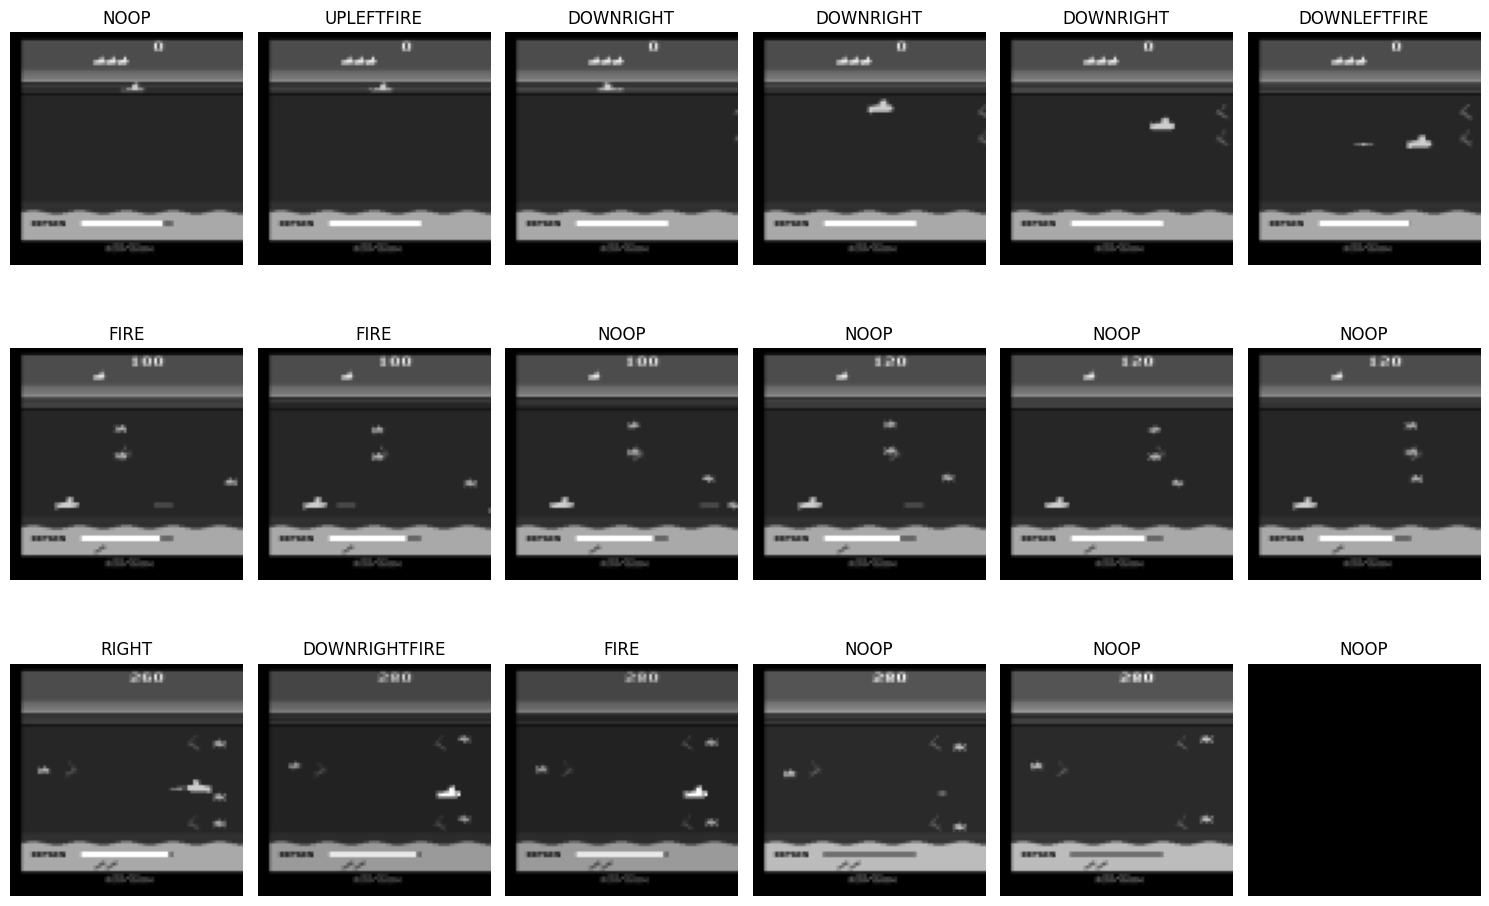

In [54]:
plt.figure(figsize=(15, 10))

for i, traj in enumerate([0,
 3,
 4,]):
    print("Trajectory Shape:", final_obs_sq[traj].shape)
    # We will plot only the first frame from each stack to avoid consecutive identical frames
    # Assuming every 4th frame is the start of a new stack
    for j in range(0, 30, 4):  # Skip every 4 frames to get to the start of the next stack
        # Calculate the subplot index, but normalize j to reflect that we're skipping frames
        subplot_index = i * (30 // 5) + (j // 5) + 1
        plt.subplot(3, (30 // 5), subplot_index)  
        
        # Plot the first frame from the current stack
        plt.imshow(final_obs_sq[traj][j][0], cmap='gray')

        # Get tensor value as an integer and use it as a key to the action dictionary
        corr_action = int(final_act_sq[traj][j].item())
        # Print the action name on top of each sub-image
        plt.title(action_dict[corr_action])
        plt.axis('off')

plt.tight_layout()
plt.show()